In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from scipy.spatial import distance
from sklearn.decomposition import PCA
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
iris = load_iris()
wine = load_wine()

In [3]:
features = pd.DataFrame(data=iris['data'],columns=iris['feature_names'])
dataI = features
dataI['target']=iris['target']
dataI['class']=dataI['target'].map(lambda ind: iris['target_names'][ind])
dataI.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,class
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [4]:
features = pd.DataFrame(data=wine['data'],columns=wine['feature_names'])
data = features
data['target']=wine['target']
data['class']=data['target'].map(lambda ind: wine['target_names'][ind])
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


Text(0, 0.5, 'malic_acid')

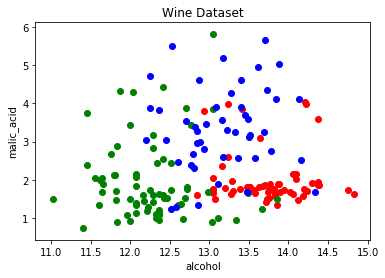

In [5]:
# create color dictionary
colors = {'class_0':'r', 'class_1':'g', 'class_2':'b'}
# create a figure and axis
fig, ax = plt.subplots()
# plot each data-point
for i in range(len(data['alcohol'])):
    ax.scatter(data['alcohol'][i], data['malic_acid'][i],color=colors[data['class'][i]])
# set a title and labels
ax.set_title('Wine Dataset')
ax.set_xlabel('alcohol')
ax.set_ylabel('malic_acid')

Text(0, 0.5, 'sepal_width')

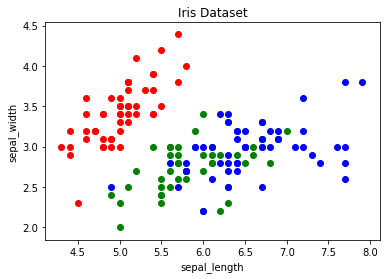

In [6]:
# create color dictionary
colors = {'setosa':'r', 'versicolor':'g', 'virginica':'b'}
# create a figure and axis
fig, ax = plt.subplots()
# plot each data-point
for i in range(len(dataI['sepal length (cm)'])):
    ax.scatter(dataI['sepal length (cm)'][i], dataI['sepal width (cm)'][i],color=colors[dataI['class'][i]])
# set a title and labels
ax.set_title('Iris Dataset')
ax.set_xlabel('sepal_length')
ax.set_ylabel('sepal_width')

In [20]:
def plot(x, v, u, c):

    fig = plt.figure()
    u = np.argmax(u, axis=0)
    x = x.T

    for j in range(c):
        plt.scatter(x[0][u == j], x[1][u == j], alpha=0.8)
        plt.scatter(v[j][0], v[j][1], s=500 , marker="*")
        
    plt.show()

In [8]:
class Fuzzy_C_Means:
    def __init__(self, data, clusters, fuzzifier, error_tolerance, iterations):
        self.z = data
        self.c = clusters
        self.m = fuzzifier
        self.e = error_tolerance
        self.l = iterations
        
    def compute_distance(self,x,V):
        return distance.cdist(x.T, V, 'euclidean').T
    
    def update_partition_matrix(self,dist,m):
        exp_dist = dist ** (2.0/m-1)
        return exp_dist / np.sum(exp_dist, axis=0, keepdims=1) 
    
    def compute_clusters(self,x,U,m):
        exp_U = np.power(U,m) 
        p1 = exp_U.dot(x.T)
        p2 = np.sum(exp_U,  axis=1)
        p2 = np.reshape(p2, (-1, self.c))
        return np.divide(p1,p2.T)
    
    def cmeans(self):
        Datapoints,Features = self.z.shape

        x = self.z.T

        V = np.empty((self.l, self.c, Features))
        V[0] = np.array(x[:,np.random.choice(x.shape[1], size = self.c)].T)
        U = np.zeros((self.l, self.c, Datapoints))    

        i = 0
        while True:
            distance = self.compute_distance(x,V[i])
            U[i] = self.update_partition_matrix(distance,self.m)
            V[i+1] = self.compute_clusters(x,U[i],self.m)
            
            if np.linalg.norm(U[i - 1] - U[i]) < self.e:
                break

            i += 1

        return V[i],U[i]

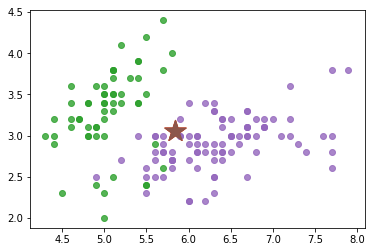

In [9]:
fcm = Fuzzy_C_Means(iris.data, len(iris.target_names) , 1.5 , 0.0001 , 100)
v, u =fcm.cmeans()

plot(iris.data, v, u, len(iris.target_names))

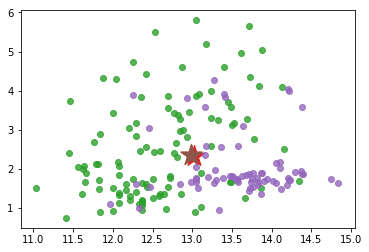

In [10]:
fcm = Fuzzy_C_Means(wine.data, len(wine.target_names), 1.5, 1 , 200)

v, u = fcm.cmeans()

plot(wine.data, v, u, len(wine.target_names))

In [11]:
class GustafsonKessel_C_Means:
    def __init__(self, data, clusters, fuzzifier, error_tolerance, iterations):
        self.z = data
        self.c = clusters
        self.m = fuzzifier
        self.e = error_tolerance
        self.l = iterations
        
    def compute_distance(self, x, V, F, n, m):
        F = F+0.00001*np.random.rand(n, n)
        zk_V = np.expand_dims(x.reshape(x.shape[0],1,-1) - V.reshape(-1,V.shape[0],1), axis=3)
        det = np.power(np.linalg.det(F)+0.00001, 1 / n)
        inv = np.linalg.inv(F)
        detinv = det.reshape(-1, 1, 1) * inv
        temp = np.matmul(zk_V.transpose((0, 1, 3, 2)), detinv)
        zk_V = np.squeeze(zk_V)
        temp = np.squeeze(temp)
        zk_V = np.einsum('ijk->jik', zk_V)
        temp = np.einsum('ijk->jki', temp)
        output = np.matmul(temp, zk_V).squeeze().T
        output = output[0, :, :]
        return np.fmax(output, 0.00001).T
    
    def update_partition_matrix(self, dist, m):
        exp_dist = dist ** (2.0/m-1)
        return exp_dist / np.sum(exp_dist)
    
    def compute_clusters(self, x, U, m):
        exp_U = np.power(U,m) 
        p1 = exp_U.dot(x.T)
        p2 = np.sum(exp_U,  axis=1)
        p2 = np.reshape(p2, (-1, 3))
        return np.divide(p1,p2.T)
    
    def compute_cluter_covariance_matrix(self, U, x, V, m, n):
        exp_U = np.power(U,m) 
        mx1 = np.ones((3,n))
        xV = x - (V.T.dot(mx1))
        xV = xV[0].T
        xV2 = np.multiply(xV, xV[:, np.newaxis])
        P1 = (np.sum(exp_U) * xV2)
        P2 = np.sum(exp_U)
        return np.divide(P1,P2)
    
    def cmeans(self):
        Datapoints,Features = self.z.shape

        x = self.z.T

        V = np.empty((self.l, self.c, Features))
        V[0] = np.array(x[:,np.random.choice(x.shape[1], size = self.c)].T)
        
        U = np.zeros((self.l, self.c, Datapoints))
        U[0] = np.array(x[np.random.choice(x.shape[0], size = self.c),:])
        
        F = np.zeros((self.l, self.c, Datapoints, Datapoints))

        i = 0
        distance = 0
        while True:
            
            F[i] = self.compute_cluter_covariance_matrix(U[i], x, V[i], self.m, Datapoints)
            
            for j in range(self.c):
                distance = self.compute_distance(x,V[i],F[i][j],Datapoints,Features)
                
            U[i] = self.update_partition_matrix(distance, self.m)            

            V[i+1] = self.compute_clusters(x, U[i], self.m)
            
            if np.linalg.norm(U[i - 1] - U[i]) < self.e:
                break
                
            i += 1

        return V[i],U[i]

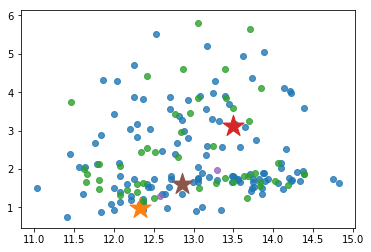

In [17]:
gcm = GustafsonKessel_C_Means(wine.data, len(wine.target_names), 1.2, 0.1 , 200)

v, u = gcm.cmeans()

plot(wine.data, v, u, len(wine.target_names))

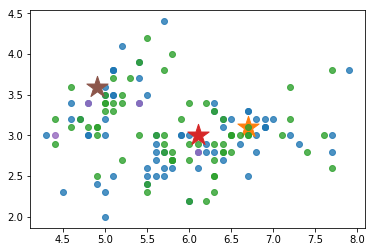

In [21]:
gcm = GustafsonKessel_C_Means(iris.data, len(iris.target_names) , 1.3 , 1 , 200)
v, u =gcm.cmeans()


plot(iris.data, v, u, len(iris.target_names))